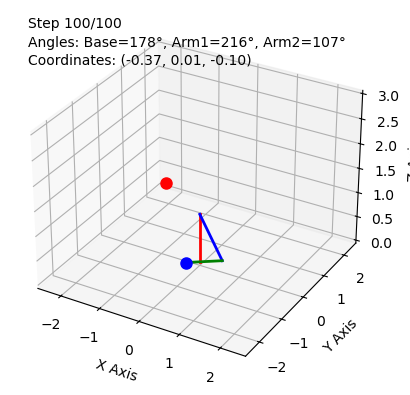

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.animation as animation

# Generate random array with specific behavior
def generate_random_array(size):
    random_array = [180]
    for _ in range(1, size):
        change = np.random.choice(range(-10, 11))  # Random choice from -10 to 10
        next_value = random_array[-1] + change
        if next_value < 0:
            next_value = 360
        elif next_value > 360:
            next_value = 0
        random_array.append(next_value)
    return random_array

# Generate three random arrays
random_array_x = generate_random_array(100)
random_array_y = generate_random_array(100)
random_array_z = generate_random_array(100)

# Generate a random target point within the robot's workspace
def generate_target_point():
    angle1 = np.radians(np.random.uniform(0, 360))
    angle2 = np.radians(np.random.uniform(0, 180))
    angle3 = np.radians(np.random.uniform(0, 180))

    base_start = (0, 0, 0)
    base_end = (0, 0, 1)

    arm1_start = base_end
    arm1_end_x = arm1_start[0] + np.cos(angle1) * np.sin(angle2)
    arm1_end_y = arm1_start[1] + np.sin(angle1) * np.sin(angle2)
    arm1_end_z = arm1_start[2] + np.cos(angle2)
    arm1_end = (arm1_end_x, arm1_end_y, arm1_end_z)

    arm2_start = arm1_end
    arm2_end_x = arm2_start[0] + np.cos(angle1) * np.sin(angle3)
    arm2_end_y = arm2_start[1] + np.sin(angle1) * np.sin(angle3)
    arm2_end_z = arm2_start[2] + np.cos(angle3)
    arm2_end = (arm2_end_x, arm2_end_y, arm2_end_z)

    return arm2_end

# Target point in workspace
target_point = generate_target_point()

# Initialize the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(0, 3)

# Set axis labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Line objects for the arms
base_line, = ax.plot([], [], [], 'r-', linewidth=2)
first_arm_line, = ax.plot([], [], [], 'b-', linewidth=2)
second_arm_line, = ax.plot([], [], [], 'g-', linewidth=2)
end_point, = ax.plot([], [], [], 'bo', markersize=8)
target_marker, = ax.plot([target_point[0]], [target_point[1]], [target_point[2]], 'ro', markersize=8, label='Target')

# Add a text annotation for progress
progress_text = ax.text2D(0.05, 0.95, "", transform=ax.transAxes)
angle_text = ax.text2D(0.05, 0.90, "", transform=ax.transAxes)
coord_text = ax.text2D(0.05, 0.85, "", transform=ax.transAxes)

# Update function for animation
def update(frame):
    angle1 = np.radians(random_array_x[frame])
    angle2 = np.radians(random_array_y[frame])
    angle3 = np.radians(random_array_z[frame])

    # Base starts at (0, 0, 0) and ends at (0, 0, 1)
    base_start = (0, 0, 0)
    base_end = (0, 0, 1)

    # First arm starts at (0, 0, 1) and ends based on angles 1 and 2
    arm1_start = base_end
    arm1_end_x = arm1_start[0] + np.cos(angle1) * np.sin(angle2)
    arm1_end_y = arm1_start[1] + np.sin(angle1) * np.sin(angle2)
    arm1_end_z = arm1_start[2] + np.cos(angle2)
    arm1_end = (arm1_end_x, arm1_end_y, arm1_end_z)

    # Second arm starts at the end of the first arm and ends based on angles relative to arm1
    arm2_start = arm1_end
    arm2_end_x = arm2_start[0] + np.cos(angle1) * np.sin(angle3)
    arm2_end_y = arm2_start[1] + np.sin(angle1) * np.sin(angle3)
    arm2_end_z = arm2_start[2] + np.cos(angle3)
    arm2_end = (arm2_end_x, arm2_end_y, arm2_end_z)

    # Update the base line
    base_line.set_data([base_start[0], base_end[0]], [base_start[1], base_end[1]])
    base_line.set_3d_properties([base_start[2], base_end[2]])

    # Update the first arm line
    first_arm_line.set_data([arm1_start[0], arm1_end[0]], [arm1_start[1], arm1_end[1]])
    first_arm_line.set_3d_properties([arm1_start[2], arm1_end[2]])

    # Update the second arm line
    second_arm_line.set_data([arm2_start[0], arm2_end[0]], [arm2_start[1], arm2_end[1]])
    second_arm_line.set_3d_properties([arm2_start[2], arm2_end[2]])

    # Update the end point
    end_point.set_data([arm2_end[0]], [arm2_end[1]])
    end_point.set_3d_properties([arm2_end[2]])

    # Update the progress text
    progress_text.set_text(f"Step {frame + 1}/{len(random_array_x)}")
    angle_text.set_text(f"Angles: Base={random_array_x[frame]}°, Arm1={random_array_y[frame]}°, Arm2={random_array_z[frame]}°")
    coord_text.set_text(f"Coordinates: ({arm2_end[0]:.2f}, {arm2_end[1]:.2f}, {arm2_end[2]:.2f})")

    return base_line, first_arm_line, second_arm_line, end_point, target_marker, progress_text, angle_text, coord_text

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(random_array_x), interval=100, blit=True)

# Save the animation as a .gif
ani.save('3d_arm_animation_with_target.gif', writer='pillow')

plt.show()


In [4]:
!pip install -q gymnasium stable_baselines3 

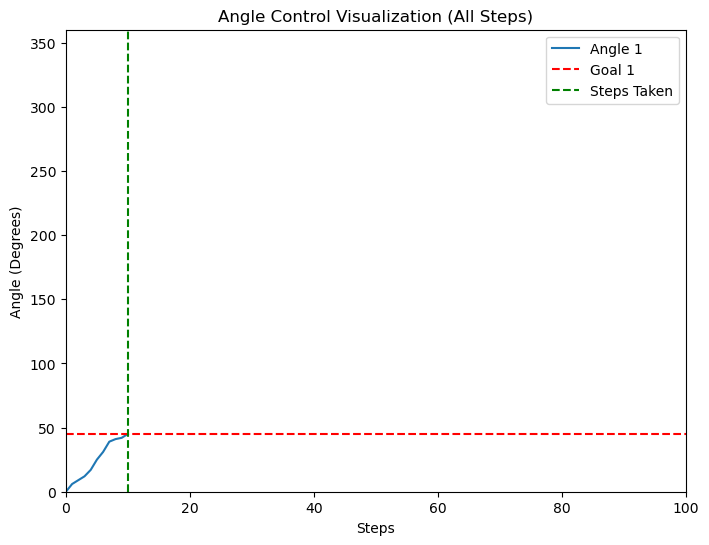

Total reward: 557


In [107]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt


class AngleControlEnv(gym.Env):
    def __init__(self):
        super(AngleControlEnv, self).__init__()

        # Define action space: 3 angles with 3 possible actions each (increase, decrease, stay)
        self.action_space = spaces.MultiDiscrete([21])

        # Observation space: 3 angles and 3 goal angles (all integers between 0 and 360)
        self.observation_space = spaces.Box(low=0, high=360, shape=(self.action_space.shape[0] * 2,), dtype=np.int32)

        # Environment state
        self.angles = np.zeros(self.action_space.shape[0], dtype=np.int32)  # Current angles
        self.goal = np.random.randint(0, 361, size=self.action_space.shape[0], dtype=np.int32)  # Random goal angles
        self.steps = 0  # Step counter
        self.max_steps = 100  # Maximum number of steps
        self.last_distance = 360 * self.action_space.shape[0]
        self.angle_history = []  # To track angles over steps

    def reset(self, seed=None):
        """Resets the environment to an initial state and returns an initial observation."""
        self.angles = np.zeros(self.action_space.shape[0], dtype=np.int32)
        self.goal = np.random.randint(0, 361, size=self.action_space.shape[0], dtype=np.int32)
        self.steps = 0
        self.angle_history = [self.angles.copy()]
        return np.concatenate((self.angles, self.goal)), {}

    def step(self, action):
        """Takes an action and returns the next state, reward, done, and info."""
        action = action - (self.action_space.nvec[0] - 1) // 2
        # Apply the action to each angle
        for i in range(self.action_space.shape[0]):
            if action[i] < 0:  # Decrease
                self.angles[i] = (self.angles[i] - action[i]) % 361
            elif action[i] > 0:  # Increase
                self.angles[i] = (self.angles[i] + action[i]) % 361

        # Calculate reward and check if the goal is reached
        self.steps += 1
        done = False
        reward = 0

        # Compute the shortest distance for each angle
        diff = np.abs(self.angles - self.goal)
        shortest_distance = np.minimum(diff, 360 - diff)

        self.angle_history.append(self.angles.copy())

        # Sum of distances
        self.distance = np.sum(shortest_distance)
        reward += int(self.last_distance - self.distance)
        self.last_distance = self.distance

        if np.array_equal(self.angles, self.goal):
            reward = self.max_steps * 2  # Reward for reaching the goal
            done = True

        # Check if maximum steps are reached
        if self.steps >= self.max_steps:
            done = True

        # Return observation, reward, done, and additional info
        obs = np.concatenate((self.angles, self.goal))
        return obs, reward, done, False, {}

    def render(self, mode='human'):
        """Renders all the values for all steps after the environment is done, including max_steps on the x-axis."""
        if mode == 'human':
            steps = list(range(len(self.angle_history)))
            angles_array = np.array(self.angle_history)

            # Create the plot
            fig, ax = plt.subplots(figsize=(8, 6))
            for i in range(self.action_space.shape[0]):
                ax.plot(steps, angles_array[:, i], label=f'Angle {i + 1}')
                ax.axhline(y=self.goal[i], color='r', linestyle='--', label=f'Goal {i + 1}')

            # Set title and labels
            ax.set_title('Angle Control Visualization (All Steps)')
            ax.set_xlabel('Steps')
            ax.set_ylabel('Angle (Degrees)')

            # Set x-axis range to include max_steps
            ax.set_xlim(0, self.max_steps)
            ax.set_ylim(0, 360)

            # Highlight the total number of steps taken
            ax.axvline(len(self.angle_history) - 1, color='g', linestyle='--', label='Steps Taken')

            # Add legend
            ax.legend(loc='upper right')

            # Show the plot
            plt.show()


    def close(self):
        """Cleans up the environment."""
        pass


# Example usage
if __name__ == "__main__":
    env = AngleControlEnv()
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = env.action_space.sample()  # Take a random action
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    env.render()  # Render all values after done
    print(f"Total reward: {total_reward}")
    env.close()


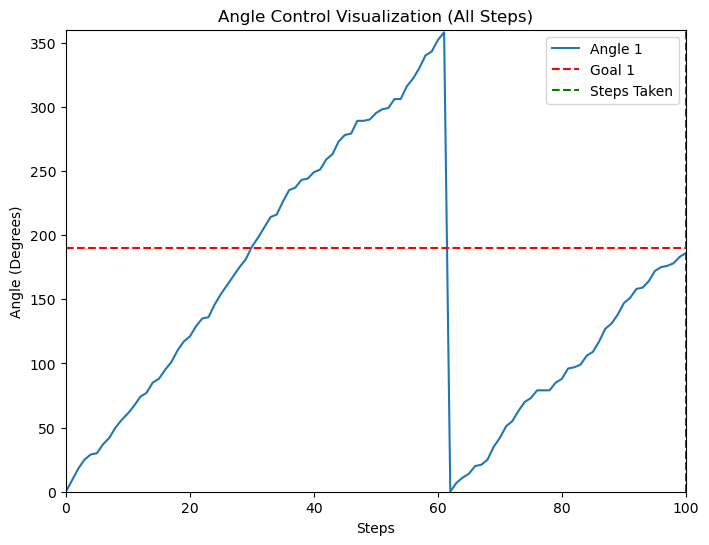

Total reward: 161


In [109]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env


# Function to create and wrap the custom environment
def create_env(env_class):
    return env_class()

# Create a single environment for testing
single_env = AngleControlEnv()

# Check the environment to ensure it follows Gymnasium API conventions
check_env(single_env, warn=True)

# Create parallel environments
vec_env = make_vec_env(lambda: create_env(AngleControlEnv), n_envs=4)

# Define and train the PPO model
model = PPO("MlpPolicy", vec_env, verbose=0)
model.learn(total_timesteps=100_000)

# Test the trained model
obs, _ = single_env.reset()
done = False
total_reward = 0
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info, _ = single_env.step(action)
    total_reward += rewards
single_env.render()
print(f"Total reward: {total_reward}")
single_env.close()